In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

this_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('text', usetex=True)
from IPython.utils import io
import shutil

In [3]:
meta = pd.read_csv('disentangled_typicality_scores.csv')
meta.filter(like='typicality').head(3)

,dinov2_vitb14_typicality,disentangled_embeddings_concat_typicality,Color_typicality,Fabric_typicality,Fit_typicality,Neckline_typicality,Pattern_typicality,Collar_typicality,Length_typicality,Shape_typicality,Sleeve_Length_typicality
0,0.824377,0.640473,0.999838,-0.282699,0.505521,-0.246991,-0.322974,-0.169511,0.094209,-0.418600,-0.145974
1,0.802438,0.040529,-0.504503,-0.480128,0.063911,-0.246480,-0.218496,-0.132414,0.145729,-0.413614,0.769613
2,0.811183,0.747291,0.999917,0.999731,0.069285,0.037668,-0.131717,-0.138936,0.100062,-0.415431,-0.161330


### Helper Functions

In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(this_wd)
    return G

G = setup_generator()

In [6]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
    return img

In [7]:
os.chdir(f"{ROOT_PATH}/2_Inversion/PTI/")
from pti_utils import load_pti
os.chdir(this_wd)

def generate_pti(latent, G_PTI):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    img = (gen.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
    return img

Using cpu as device


### Typicality Helper Functions

In [8]:
# Load in precomputed morphs
morphs = pickle.load(open('morphs.pkl', 'rb'))
morphs.keys()

dict_keys(['dinov2_vitb14', 'disentangled_embeddings_concat', 'Color', 'Fabric', 'Fit', 'Neckline', 'Pattern', 'Collar', 'Length', 'Shape', 'Sleeve_Length'])

In [9]:
from torch.nn.functional import cosine_similarity
def calculate_typicality(imgs, embedding_type):

    # Save image in temp folder
    temp_folder = this_wd + '/temp/'
    os.makedirs(temp_folder+'image/', exist_ok = True)
    for i in range(len(imgs)):
        imgs[i].save(f"{temp_folder}image/{i}.jpg")

    # Run disentangling model inference and sace embeddings
    os.chdir(f"{ROOT_PATH}/4_Assessor/disentangled_representations")
    from infer import infer

    model_id = 5
    with io.capture_output() as captured:
        infer(
                checkpoint=f'{DATA_PATH}/Models/disentangled_representations/models/{model_id}-model-best_valid_loss.pt',
                img_dir=temp_folder+'image/',
                save_dir=temp_folder+"inference/",
                batch_size=64,
                verbose=False,
                N=None
            )

    os.chdir(this_wd)
    global results
    # Load inference results
    results = pickle.load(open(temp_folder+f"inference/{model_id}.pkl", 'rb'))
    # Remove #.jpg from all filenames
    results['filenames'] = [f.split('.')[0] for f in results['filenames']]
    # Concatenate all subspaces as the final embedding
    results['disentangled_embeddings_concat'] = torch.cat([results['disentangled_embeddings'][key] for key in results['disentangled_embeddings'].keys()], dim = 1)
    # Get Sub Embeddings 
    for sub_embedding in results['disentangled_embeddings'].keys():
        results[sub_embedding] = results['disentangled_embeddings'][sub_embedding]
    results.keys()

    # Calculate typicality scores based on embedding type
    typicality_scores = [elem.item() for elem in cosine_similarity(morphs[embedding_type], results[embedding_type])]
    typicality_scores = dict(zip(results['filenames'], typicality_scores))

    # Remove temp folder
    shutil.rmtree(temp_folder)
    
    return typicality_scores

### InterFaceGAN Helper Functions

In [10]:
def get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)

    boundary = np.load(f"{boundaries_base_dir}boundary_dim.npy")
    boundary = torch.tensor(boundary)
    for i in range(steps):
        latent_code[i, :, :] = latent_code[i, :, :] + linspace[i] * boundary
    
    return latent_code

In [11]:
def run_example(n, embedding_type = 'disentangled_embeddings_concat', direction = 'more', steps=5, distance=15, sku = None, generator = 'SG2'):

    boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/disentangled_typicality/{embedding_type}/{n}/"

    # Load in training stats
    training_stats = pd.read_csv(f"{boundaries_base_dir}summary_stats.csv")

    # Load in original Latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    # Filter to include only SKU for which PTI exists
    pti_skus = list(glob('/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/embeddings/zalando_germany/PTI/*'))
    pti_skus = [elem.split('/')[-1] for elem in pti_skus]
    df = meta[meta.sku.isin(pti_skus)]
    global chosen_sku

    if generator == 'PTI':
        # Sample one latent
        sample = df.sample(1)
        if sku:
            sample = df[df.sku == sku]
        else: 
            sample = df.sample(1)
            chosen_sku = sample.sku.item()

        device = torch.device('cpu')
        G_PTI, latent = load_pti(chosen_sku)

        # Freeze and set to eval
        G_PTI.eval()
        for param in G_PTI.parameters():
            param.requires_grad = False

        # Send to CPU
        G_PTI = G_PTI.to(device)
        latent_code = latent.to(device)
        latent_code =latent_code.squeeze(0).flatten()

    elif generator == 'SG2':
        if sku:
            sample = df[df.sku == sku]
        else: 
            sample = df.sample(1)
            chosen_sku = sample.sku.item()
        latent_code = latents[sample.sku.item()].squeeze(0).flatten()

    # Generate Interpolations
    if direction == 'more': 
        start_distance, end_distance = 0, distance
    elif direction == 'less': 
        start_distance, end_distance = 0,  -distance

    interpolations = get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir)


    global imgs
    if generator == 'SG2':
        imgs = [generate_from_latent(interpolations[i, :, :].squeeze(0).reshape(1,16,512)) for i in range(steps)]
    elif generator == 'PTI':
        imgs = [generate_pti(interpolations[i, :, :].squeeze(0).reshape(1,16,512), G_PTI) for i in range(steps)]



    # Add real image for comparison of first inversion
    real = Image.open(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{chosen_sku}.jpg")

    imgs = [real] + imgs

    # Calculate typicality scores of generated images
    scores = calculate_typicality(imgs, embedding_type)

    fig, ax = plt.subplots(1, steps+1, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(steps+1):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
            
        if i == 0: 
            ax[i].set_title(f'Original')
        elif i == 1: 
            ax[i].set_title(f'Inversion\nTypicality: {np.round(scores[str(i)], 2)}')
        else: 
            step = np.linspace(start_distance, end_distance, steps)[i-1]
            ax[i].set_title(f"{'+' if step > 0 else ''}{step}\nTypicality: {np.round(scores[str(i)], 2)}")

    
    fig.suptitle(f"SKU: {sample.sku.item()}\nDirection: {direction} typical\nEmbedding: " + r"\textbf{" + embedding_type+"}" + "\nGenerator type: " + r"\textbf{" + generator + "}")
    plt.show()

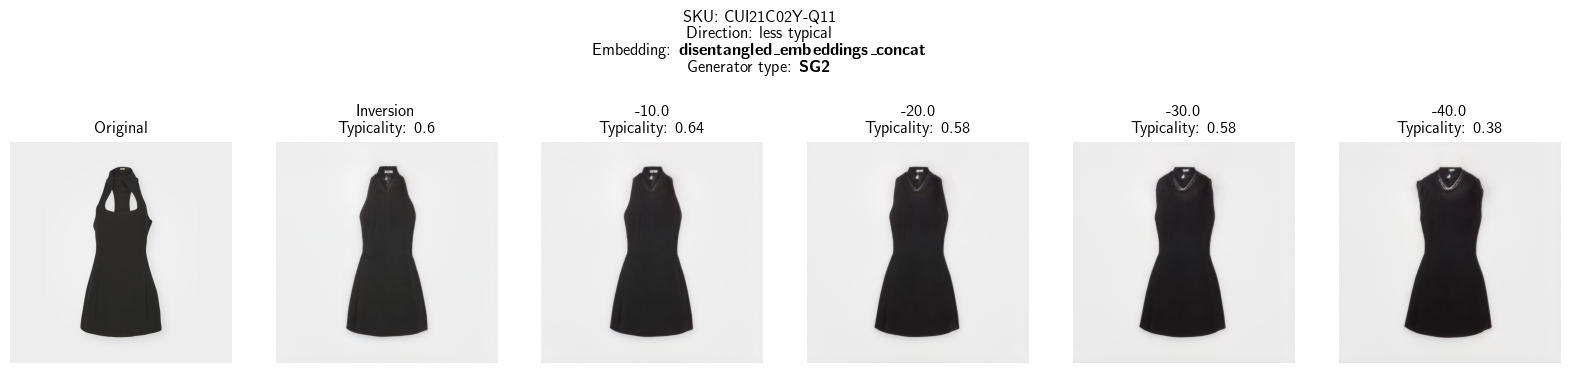

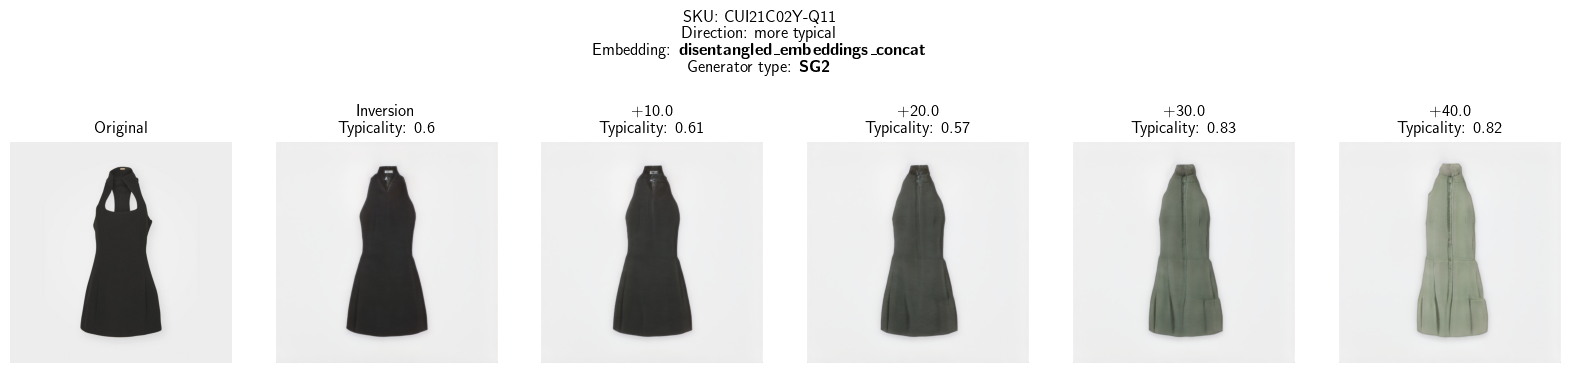

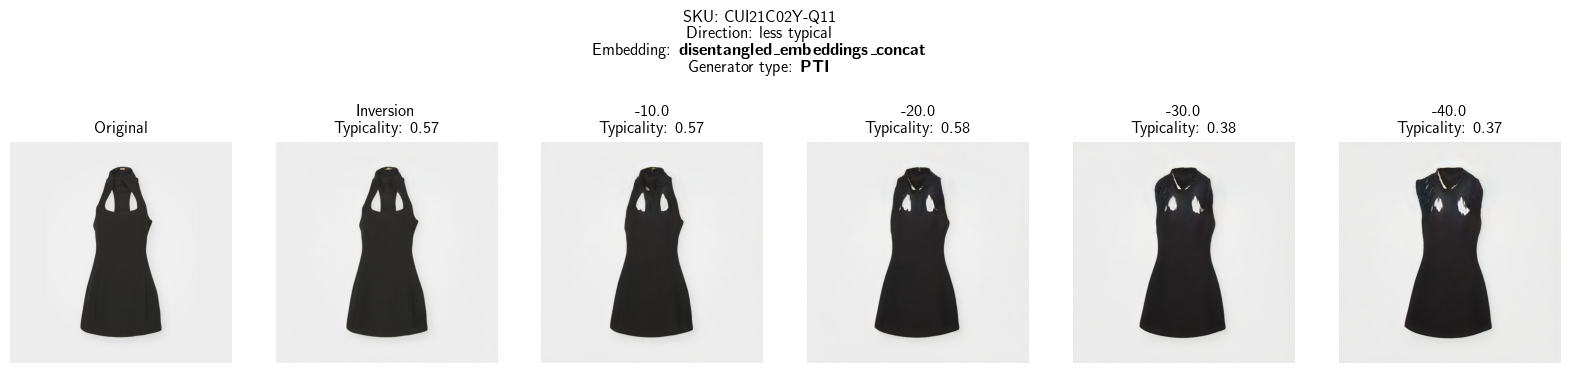

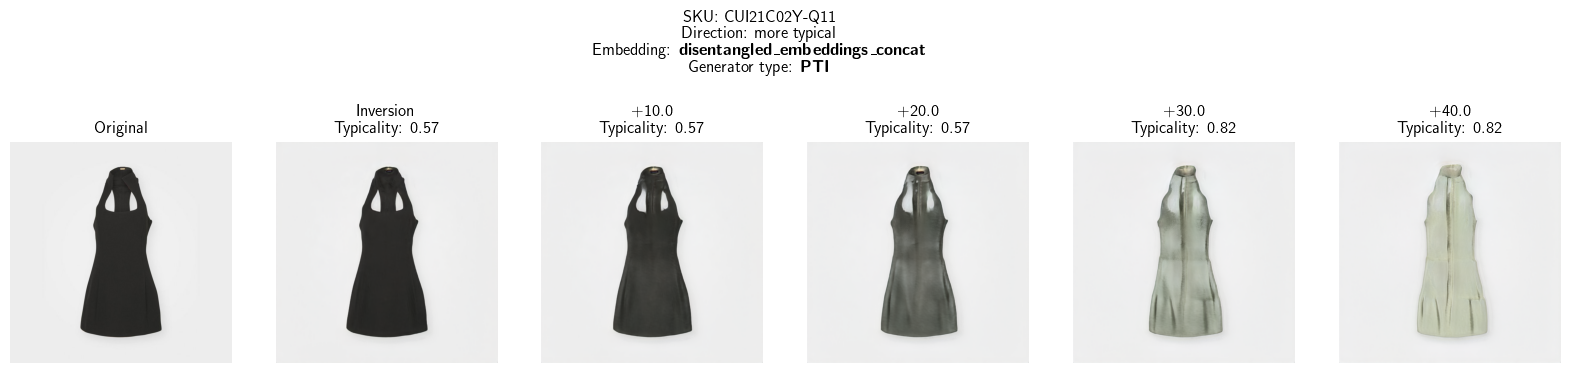


********************************************************************************************************************************************************************************************************



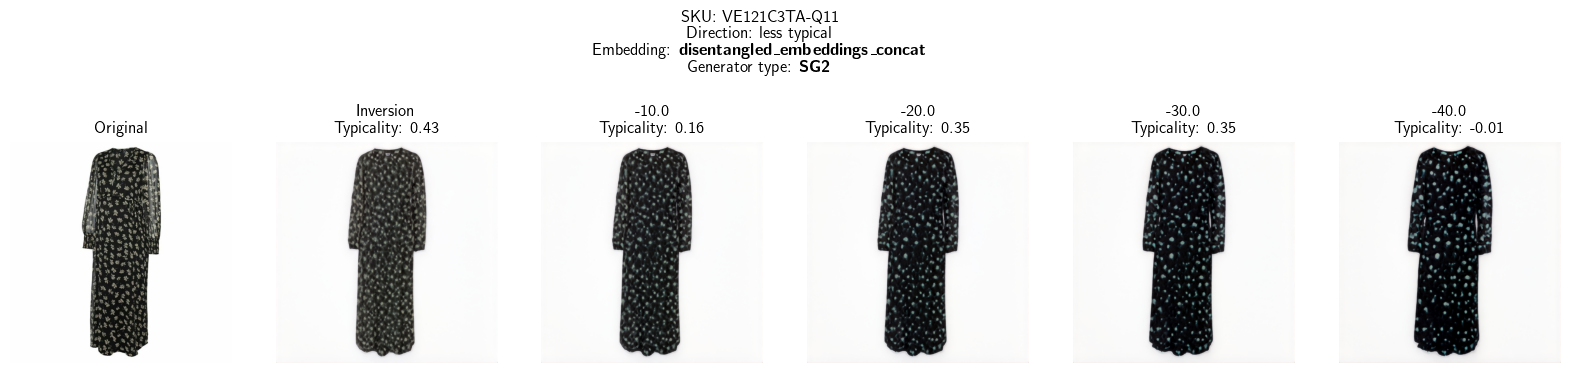

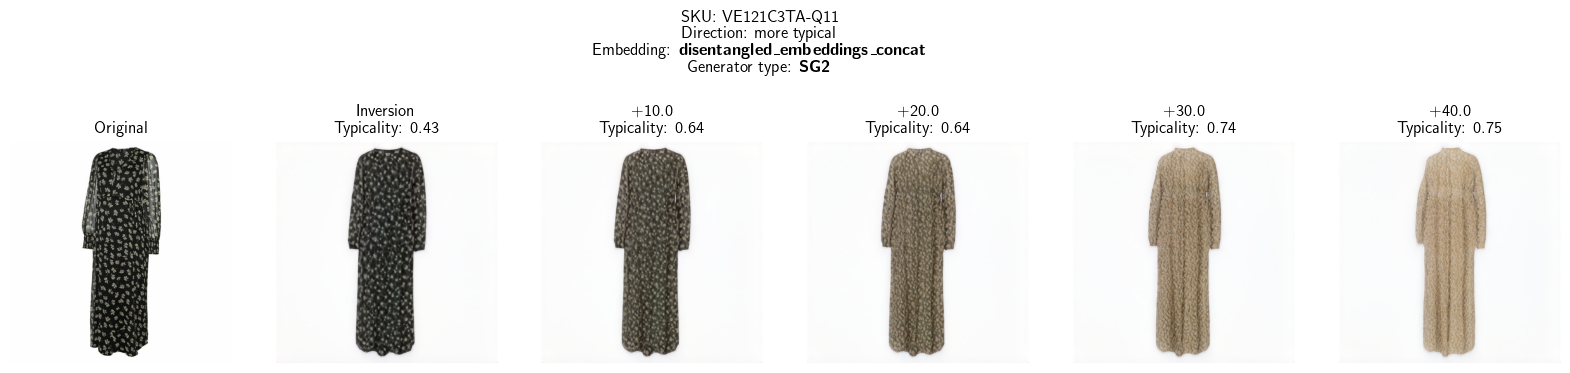

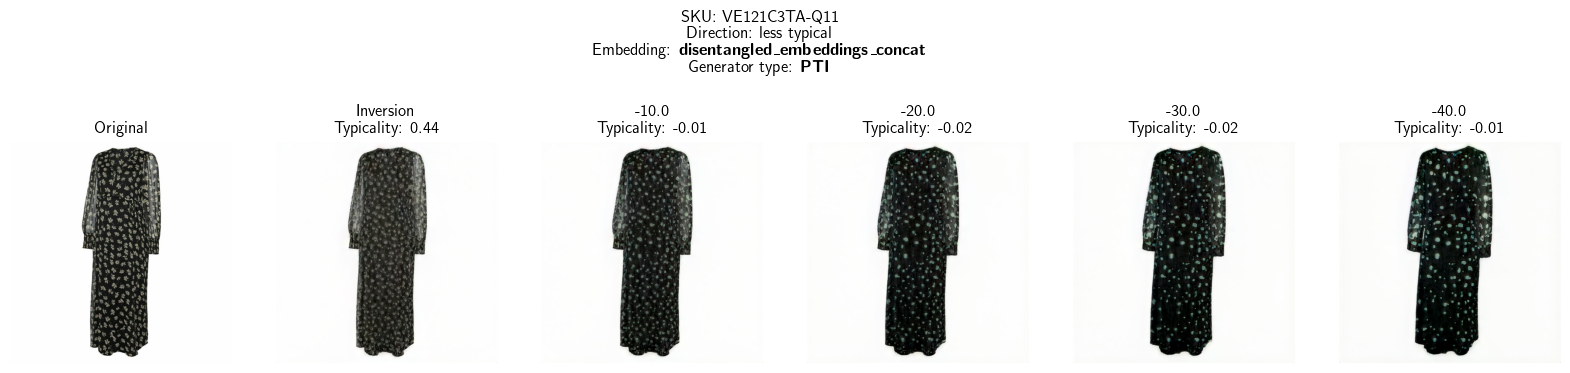

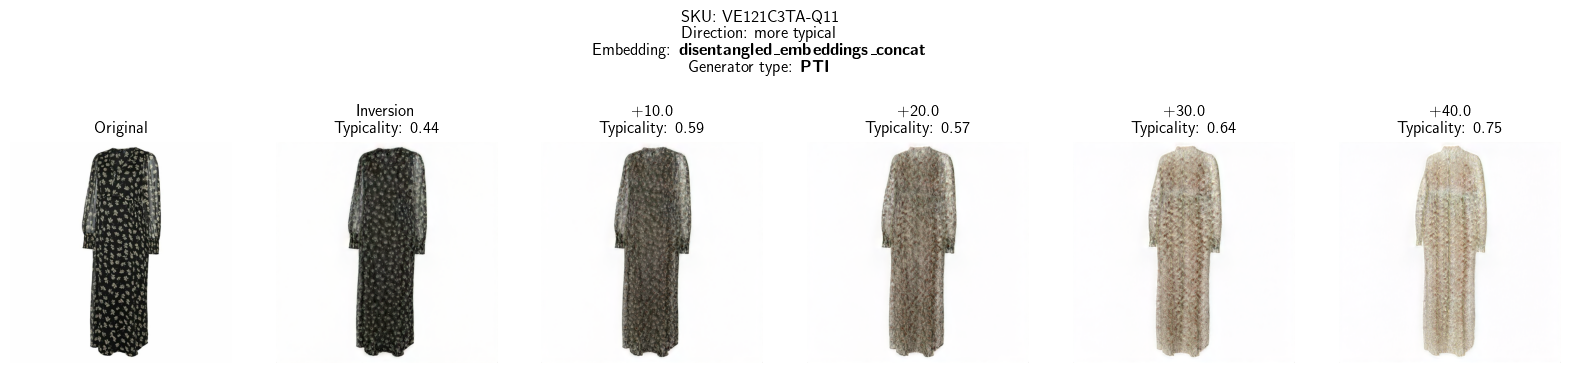


********************************************************************************************************************************************************************************************************



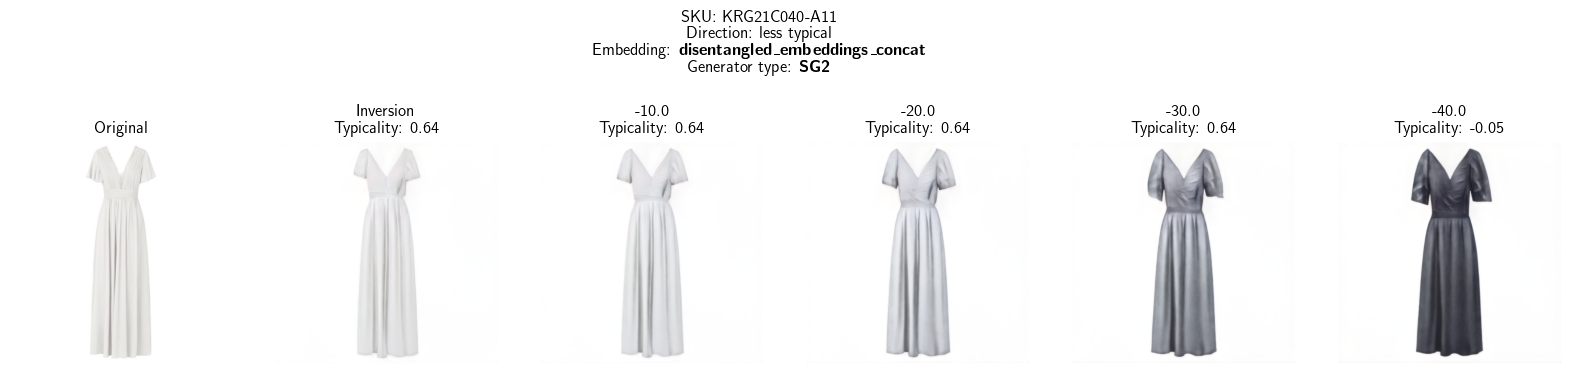

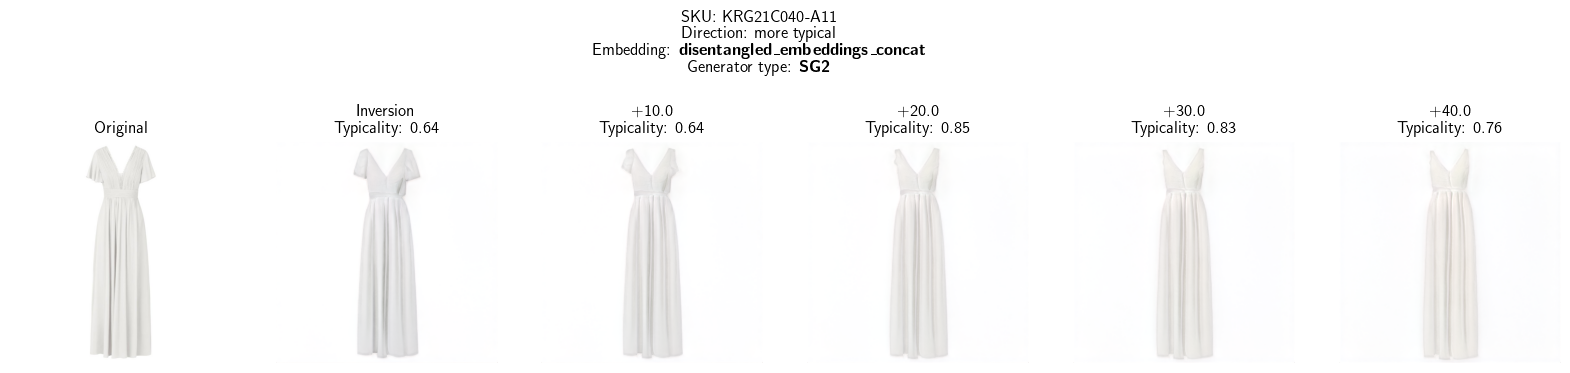

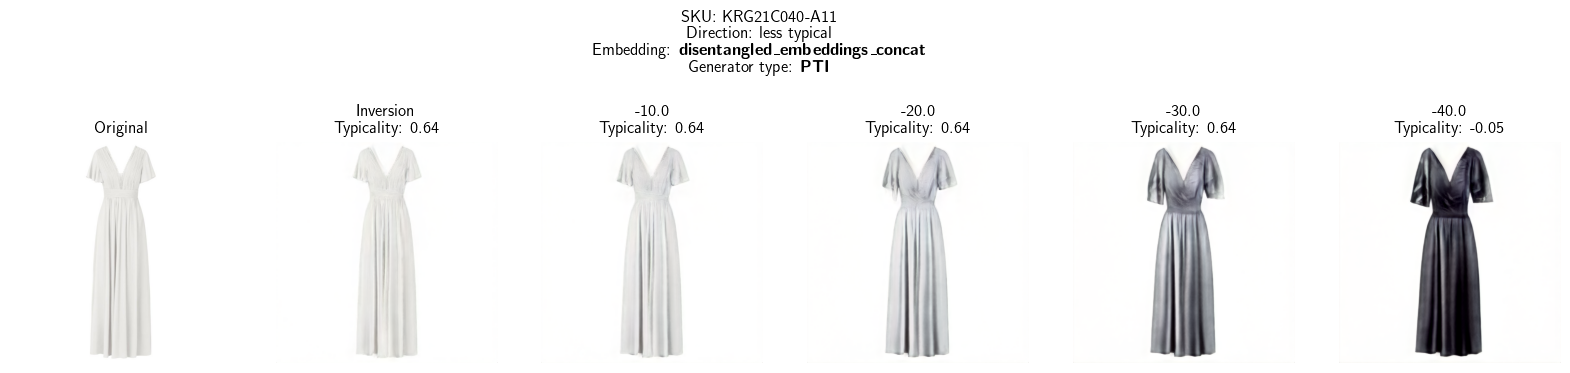

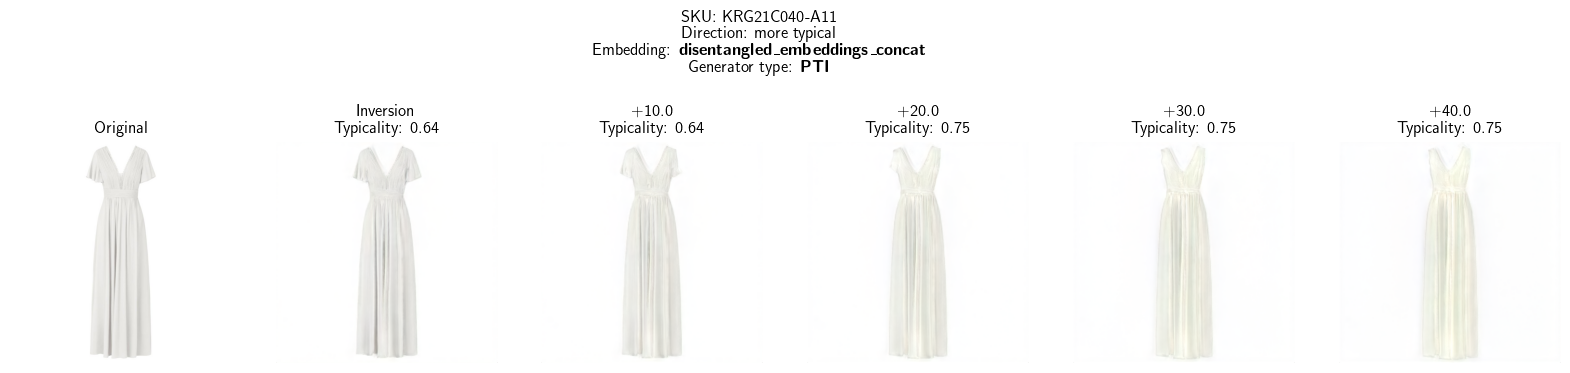


********************************************************************************************************************************************************************************************************



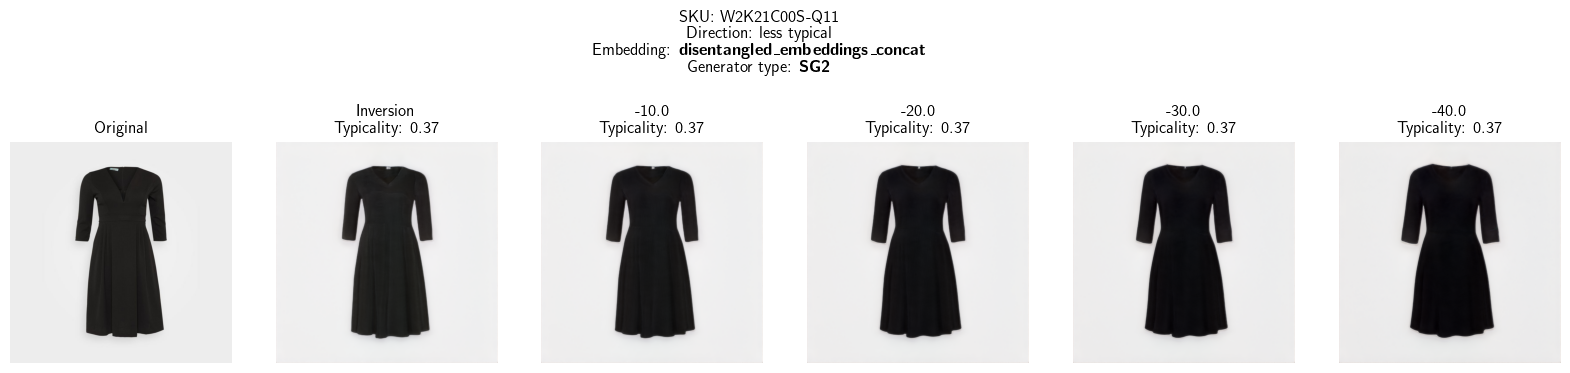

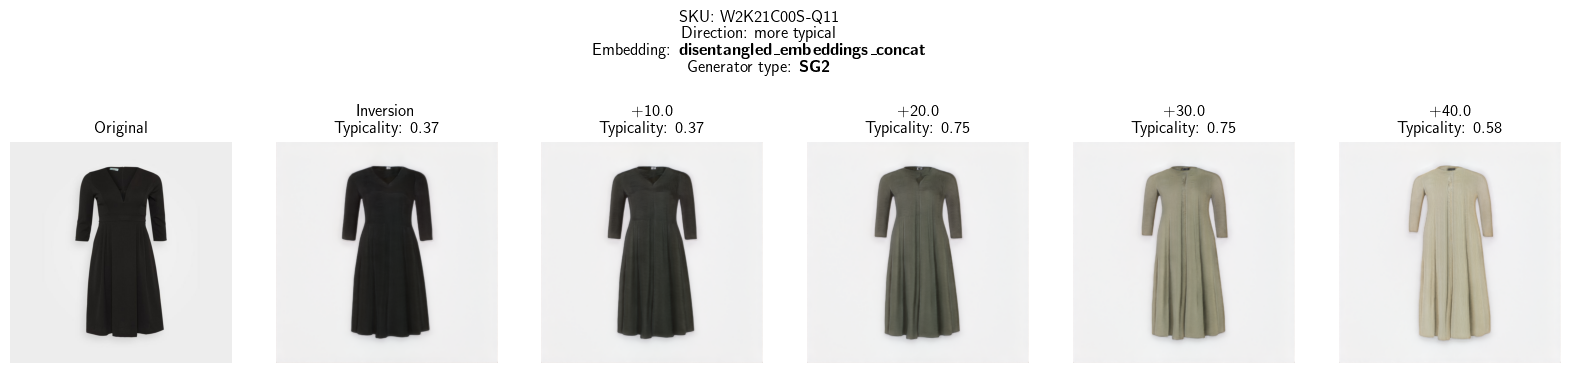

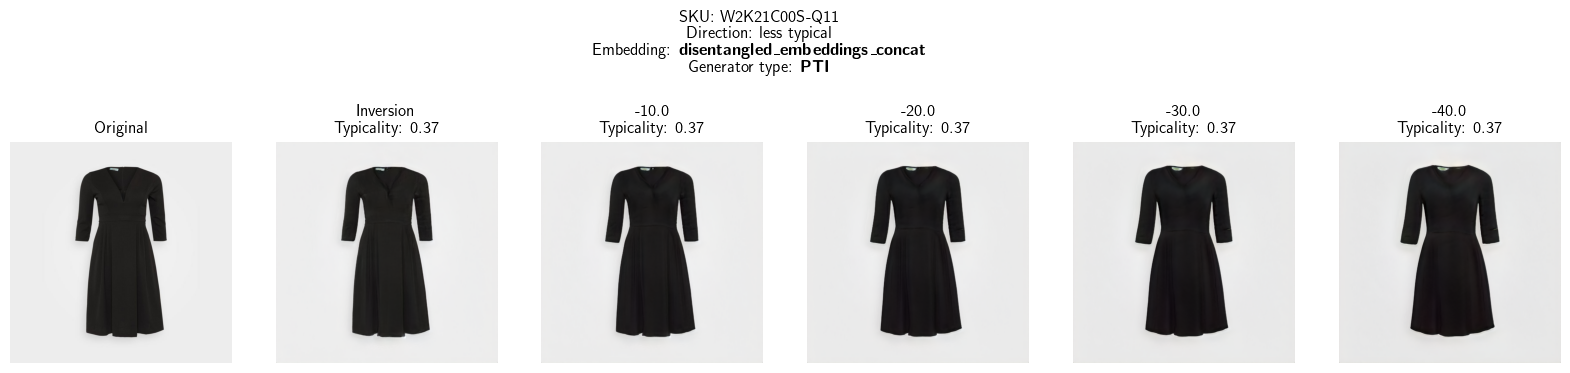

In [12]:
for _ in range(10):
    for embedding_type in['disentangled_embeddings_concat']:
        run_example(n = 1000, embedding_type = embedding_type,  direction = 'less', steps=5, distance=40, generator = 'SG2')
        run_example(n = 1000, embedding_type = embedding_type,  direction = 'more', steps=5, distance=40, sku = chosen_sku, generator = 'SG2')
        run_example(n = 1000, embedding_type = embedding_type,  direction = 'less', steps=5, distance=40, sku = chosen_sku, generator = 'PTI')
        run_example(n = 1000, embedding_type = embedding_type,  direction = 'more', steps=5, distance=40, sku = chosen_sku, generator = 'PTI')
    print(f"\n{'*'*200}\n")